## Chỉ số kinh doanh cơ bản
#### **Mục tiêu (Objectives)**

- Tính toán các KPI cơ bản của e-commerce
- Phân tích xu hướng doanh thu và đơn hàng
- Đánh giá hiệu suất kinh doanh tổng thể

## 1. Import và setup

In [154]:
# Import các thư viện cần thiết
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)      # Hiển thị tất cả cột
pd.set_option('display.width', None)            # Không giới hạn chiều rộng
pd.set_option('display.max_colwidth', None)     # Không giới hạn độ rộng cột

# Load biến môi trường từ file .env
load_dotenv()

# Lấy thông tin kết nối database
DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_GOLD = os.getenv("DB_GOLD")

# Tạo kết nối tới Gold database
gold_engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_GOLD}")


## 2. Load data 

In [155]:
# Load du lieu tat ca cac bang

df_orders = pd.read_sql_table("fact_orders", gold_engine)
df_orders_items = pd.read_sql_table("fact_order_items", gold_engine)
df_products = pd.read_sql_table("dim_products", gold_engine)
df_customers = pd.read_sql_table("dim_customers", gold_engine)
df_date = pd.read_sql_table("dim_date", gold_engine)
df_pages = pd.read_sql_table("dim_order_pages", gold_engine)
df_payments = pd.read_sql_table("dim_order_payments", gold_engine)
df_shipping = pd.read_sql_table("dim_order_shipping", gold_engine)
df_warehouses = pd.read_sql_table("dim_order_warehouses", gold_engine)
df_shop = pd.read_sql_table("dim_shop", gold_engine) 

## A. Business Metrics Overview and Revenue Metrics

### 1. Total Revenue (Tổng doanh thu)

In [156]:
# 1. Total Revenue (Tổng doanh thu)
# Tổng doanh thu trước giảm giá
total_revenue = df_orders['total_price'].sum()
print(f"Tổng doanh thu trước giảm giá: {total_revenue:,.0f} VND")
# Tổng doanh thu sau giảm giá  
total_revenue_after_discount = df_orders['total_price_after_sub_discount'].sum()
print(f"Tổng doanh thu sau giảm giá: {total_revenue_after_discount:,.0f} VND")
# Tổng giảm giá
total_discount = df_orders['total_discount'].sum()
print(f"Tổng giảm giá: {total_discount:,.0f} VND")
# Tỷ lệ giảm giá
discount_rate = (total_discount / total_revenue) * 100 if total_revenue > 0 else 0
print(f"Tỷ lệ giảm giá: {discount_rate:.2f}%")
print("\n" + "="*60)

Tổng doanh thu trước giảm giá: 17,879,077,900 VND
Tổng doanh thu sau giảm giá: 16,545,782,490 VND
Tổng giảm giá: 1,428,799,550 VND
Tỷ lệ giảm giá: 7.99%



### 2. Average Order Value - AOV (Giá trị đơn hàng trung bình)

In [157]:
# 2. Average Order Value - AOV (Giá trị đơn hàng trung bình)
total_orders = len(df_orders)
aov = total_revenue / total_orders if total_orders > 0 else 0
aov_after_discount = total_revenue_after_discount / total_orders if total_orders > 0 else 0

print(f"Tổng số đơn hàng: {total_orders:,}")
print(f"AOV trước giảm giá: {aov:,.0f} VND")
print(f"AOV sau giảm giá: {aov_after_discount:,.0f} VND")

Tổng số đơn hàng: 40,236
AOV trước giảm giá: 444,355 VND
AOV sau giảm giá: 411,218 VND


### 3. Monthly Recurring Revenue - MRR (Doanh thu định kỳ hàng tháng)

In [158]:
# 3. Monthly Recurring Revenue - MRR (Doanh thu định kỳ hàng tháng)
# Merge df_orders và df_date

df_orders['date_id'] = df_orders['date_id'].astype(int) # chuyển cột date_id sang int
df_orders = pd.merge(df_orders, df_date, left_on='date_id', right_on='date_id', how='left')

# Doanh thu theo tháng
monthly_revenue = df_orders.groupby('year_month')['total_price_after_sub_discount'].sum()
print("Doanh thu theo tháng:")
for month, revenue in monthly_revenue.items():
    if revenue > 0:
        print(f"   {month}: {revenue:,.0f} VND")

# MRR (trung bình doanh thu hàng tháng)
mrr = monthly_revenue.mean()
print(f"\n MRR (Doanh thu trung bình/tháng): {mrr:,.0f} VND")

Doanh thu theo tháng:
   2024-02: 984,180,000 VND
   2024-03: 832,252,900 VND
   2024-04: 1,383,339,000 VND
   2024-05: 628,297,500 VND
   2024-06: 2,256,658,900 VND
   2024-07: 1,416,684,000 VND
   2024-08: 377,050,000 VND
   2024-09: 790,764,100 VND
   2024-10: 1,051,660,950 VND
   2024-11: 1,363,719,020 VND
   2024-12: 3,092,223,120 VND
   2025-01: 1,610,115,000 VND
   2025-02: 524,136,000 VND
   2025-03: 208,947,000 VND
   2025-04: 25,755,000 VND

 MRR (Doanh thu trung bình/tháng): 590,920,803 VND


### 4. Revenue Growth Rate (Tỷ lệ tăng trưởng doanh thu)

In [159]:
# 4. Revenue Growth Rate (Tỷ lệ tăng trưởng doanh thu)
# Tính growth rate theo tháng
revenue_growth_rate = monthly_revenue[monthly_revenue > 0].pct_change() * 100
print("Tỷ lệ tăng trưởng doanh thu theo tháng:")
for month, growth in revenue_growth_rate.items():
    if pd.notna(growth):
        print(f"   {month}: {growth:+.2f}%")
    else:
        print(f"   {month}: N/A (tháng đầu tiên)")

Tỷ lệ tăng trưởng doanh thu theo tháng:
   2024-02: N/A (tháng đầu tiên)
   2024-03: -15.44%
   2024-04: +66.22%
   2024-05: -54.58%
   2024-06: +259.17%
   2024-07: -37.22%
   2024-08: -73.39%
   2024-09: +109.72%
   2024-10: +32.99%
   2024-11: +29.67%
   2024-12: +126.75%
   2025-01: -47.93%
   2025-02: -67.45%
   2025-03: -60.13%
   2025-04: -87.67%


### 5. BIỂU ĐỒ

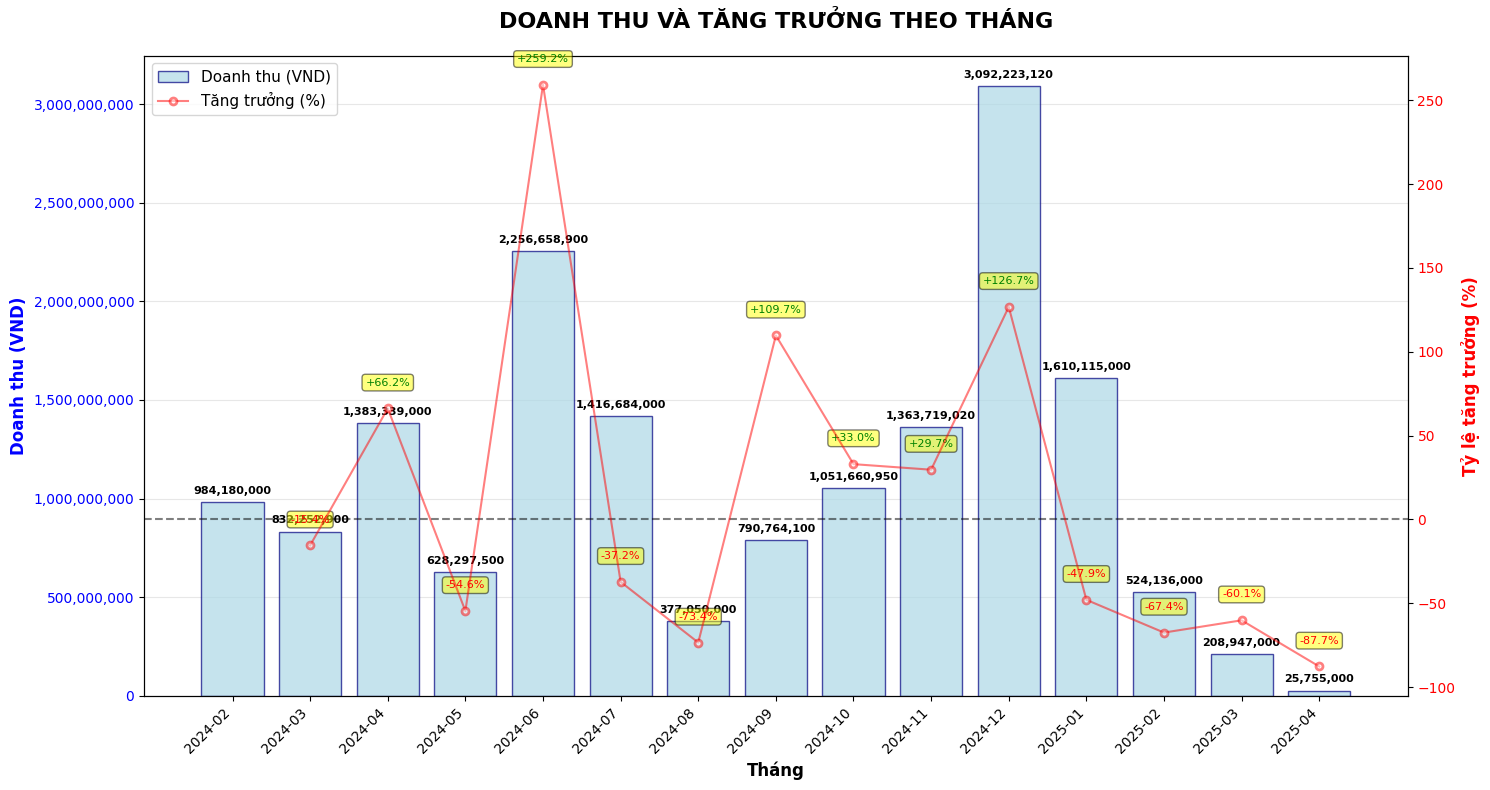

In [160]:
# Tạo figure và axis
fig, ax1 = plt.subplots(figsize=(15, 8))

# BIỂU ĐỒ CỘT (DOANH THU) - BACKGROUND
# Vẽ biểu đồ cột
monthly_revenue_filtered = monthly_revenue[monthly_revenue > 0]
bars = ax1.bar(range(len(monthly_revenue_filtered)), 
               monthly_revenue_filtered.values,
               color='lightblue', 
               alpha=0.7,
               edgecolor='navy',
               linewidth=1,
               label='Doanh thu (VND)')

# Customize biểu đồ cột
ax1.set_xlabel('Tháng', fontsize=12, fontweight='bold')
ax1.set_ylabel('Doanh thu (VND)', fontsize=12, fontweight='bold', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Format y-axis với dấu phẩy
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Thêm giá trị trên đầu mỗi cột
for i, (bar, value) in enumerate(zip(bars, monthly_revenue_filtered.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(monthly_revenue_filtered.values)*0.01,
             f'{value:,.0f}', ha='center', va='bottom', fontsize=8, fontweight='bold')


# BIỂU ĐỒ ĐƯỜNG (TĂNG TRƯỞNG) - FOREGROUND
# Tạo y-axis thứ 2 cho tăng trưởng
ax2 = ax1.twinx()

# Vẽ biểu đồ đường chồng lên
line = ax2.plot(range(len(revenue_growth_rate)), 
                revenue_growth_rate.values,
                color='red', 
                marker='o', 
                markersize=5,
                markerfacecolor='white',
                markeredgecolor='red',
                markeredgewidth=2,
                label='Tăng trưởng (%)',
                alpha=0.5,
                zorder=5)  # Đảm bảo đường ở trên cùng

# Customize y-axis thứ 2
ax2.set_ylabel('Tỷ lệ tăng trưởng (%)', fontsize=12, fontweight='bold', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Thêm đường 0% baseline
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Thêm giá trị trên mỗi điểm đường
for i, (x, y) in enumerate(zip(range(len(revenue_growth_rate)), revenue_growth_rate.values)):
    if not np.isnan(y):
        # Màu sắc dựa trên positive/negative
        color = 'green' if y >= 0 else 'red'
        ax2.annotate(f'{y:+.1f}%', 
                    xy=(x, y), 
                    xytext=(0, 15), 
                    textcoords='offset points',
                    ha='center', va='bottom',
                    fontsize=8,
                    color=color,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))


# CUSTOMIZE CHUNG
# Set x-axis labels
months = [str(month) for month in monthly_revenue_filtered.index]
ax1.set_xticks(range(len(monthly_revenue_filtered)))
ax1.set_xticklabels(months, rotation=45, ha='right')

# Grid
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_axisbelow(True)

# Legend - kết hợp cả 2
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)

# Title
plt.title('DOANH THU VÀ TĂNG TRƯỞNG THEO THÁNG', 
          fontsize=16, fontweight='bold', pad=20)

# Adjust layout
plt.tight_layout()
plt.show()

## B. Order Metrics

### 1. Total Orders (Tổng số đơn hàng)

In [161]:
total_orders = len(df_orders)
print(f"Tổng số đơn hàng: {total_orders:,}")

Tổng số đơn hàng: 40,236


### 2. Orders per Customer (Số đơn hàng trên mỗi khách hàng)

In [162]:
total_customers = len(df_customers)
orders_per_customer = total_orders / total_customers if total_customers > 0 else 0

print(f"Tổng số khách hàng: {total_customers:,}")
print(f"Tổng số đơn hàng: {total_orders:,}")
print(f"Số đơn hàng/khách hàng: {orders_per_customer:.2f}")

Tổng số khách hàng: 36,090
Tổng số đơn hàng: 40,236
Số đơn hàng/khách hàng: 1.11


In [163]:
# Phân tích chi tiết orders per customer
print(f"   Khách hàng có đơn hàng trung bình: {df_customers['order_count'].mean():.2f}")
print(f"   Khách hàng có đơn hàng nhiều nhất: {df_customers['order_count'].max()}")
print(f"   Khách hàng có đơn hàng ít nhất: {df_customers['order_count'].min()}")
    
# Phân khúc khách hàng theo số đơn hàng
single_order_customers = len(df_customers[df_customers['order_count'] == 1]) # Khách hàng 1 đơn
repeat_customers = len(df_customers[df_customers['order_count'] > 1]) # Khách hàng lặp lại
    
print(f"   Khách hàng 1 đơn: {single_order_customers:,} ({(single_order_customers/total_customers)*100:.1f}%)")
print(f"   Khách hàng lặp lại: {repeat_customers:,} ({(repeat_customers/total_customers)*100:.1f}%)")


   Khách hàng có đơn hàng trung bình: 1.12
   Khách hàng có đơn hàng nhiều nhất: 11
   Khách hàng có đơn hàng ít nhất: 0
   Khách hàng 1 đơn: 32,594 (90.3%)
   Khách hàng lặp lại: 3,494 (9.7%)


### 3. Order Completion Rate (Tỷ lệ hoàn thành đơn hàng)

In [164]:
# Phân tích theo trạng thái đơn hàng
order_status_counts = df_orders['status_name'].value_counts()

print("Phân bố đơn hàng theo trạng thái:")
for status, count in order_status_counts.items():
    percentage = (count / total_orders) * 100
    print(f"  {status}: {count:,} ({percentage:.1f}%)")

Phân bố đơn hàng theo trạng thái:
  delivered: 17,276 (42.9%)
  returned: 13,659 (33.9%)
  canceled: 4,161 (10.3%)
  new: 3,937 (9.8%)
  returning: 786 (2.0%)
  part_returned: 364 (0.9%)
  shipped: 53 (0.1%)


### 4. Order Frequency (Tần suất đặt hàng)

In [165]:
df_orders['order_date'] = pd.to_datetime(df_orders['inserted_at'])
start_date = df_orders['order_date'].min()
end_date = df_orders['order_date'].max()
days_in_period = (end_date - start_date).days + 1
    
print(f"Khoảng thời gian: {start_date.strftime('%Y-%m-%d')} đến {end_date.strftime('%Y-%m-%d')}")
print(f"Tổng số ngày: {days_in_period:,} ngày")
print(f"Tổng số khách hàng: {total_customers:,}")
print(f"Tổng số đơn hàng: {total_orders:,}")
    
# Order frequency (là số đơn hàng trung bình trên mỗi khách hàng trong một ngày)
order_frequency = total_orders / (days_in_period * total_customers) if (days_in_period * total_customers) > 0 else 0
print(f"Tần suất đặt hàng: {order_frequency:.4f} đơn/khách/ngày")
    
# Các chỉ số khác
orders_per_day = total_orders / days_in_period if days_in_period > 0 else 0
customers_per_day = total_customers / days_in_period if days_in_period > 0 else 0

print(f"   Đơn hàng/ngày: {orders_per_day:.2f}")
print(f"   Khách hàng/ngày: {customers_per_day:.2f}")
    
# Phân tích theo tháng
monthly_orders = df_orders.groupby('year_month').size()
    
print(f"Đơn hàng theo tháng:")
for month, count in monthly_orders.items():
    print(f"   {month}: {count:,} đơn")

Khoảng thời gian: 2021-12-30 đến 2025-08-16
Tổng số ngày: 1,325 ngày
Tổng số khách hàng: 36,090
Tổng số đơn hàng: 40,236
Tần suất đặt hàng: 0.0008 đơn/khách/ngày
   Đơn hàng/ngày: 30.37
   Khách hàng/ngày: 27.24
Đơn hàng theo tháng:
   2021-12: 1 đơn
   2022-01: 19 đơn
   2022-04: 13 đơn
   2022-08: 4 đơn
   2023-02: 6 đơn
   2023-03: 2 đơn
   2023-04: 14 đơn
   2023-06: 5 đơn
   2023-07: 33 đơn
   2024-02: 2,789 đơn
   2024-03: 2,613 đơn
   2024-04: 4,121 đơn
   2024-05: 1,868 đơn
   2024-06: 5,792 đơn
   2024-07: 4,339 đơn
   2024-08: 1,156 đơn
   2024-09: 1,940 đơn
   2024-10: 2,505 đơn
   2024-11: 2,452 đơn
   2024-12: 5,615 đơn
   2025-01: 3,056 đơn
   2025-02: 997 đơn
   2025-03: 625 đơn
   2025-04: 139 đơn
   2025-05: 41 đơn
   2025-06: 67 đơn
   2025-07: 10 đơn
   2025-08: 14 đơn


### 5. Visualization

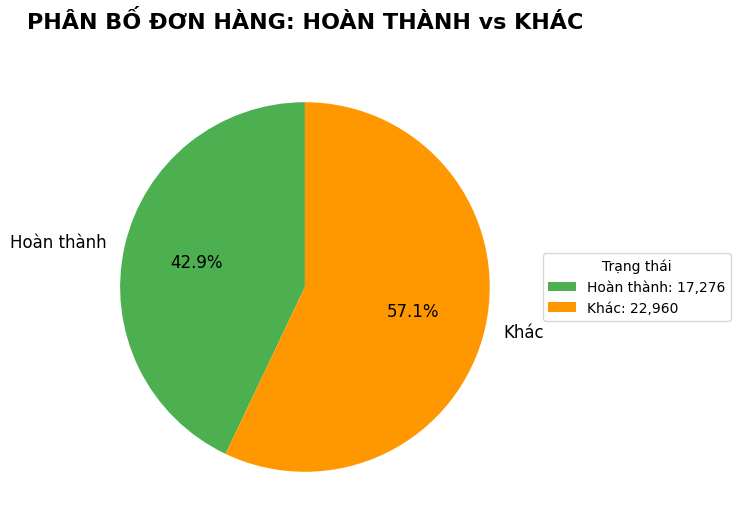

In [166]:
fig, ax = plt.subplots(figsize=(8, 6))
# Đếm delivered
delivered_count = len(df_orders[df_orders['status_name'].str.lower() == 'delivered'])
other_count = len(df_orders[df_orders['status_name'].str.lower() != 'delivered'])

# Dữ liệu cho biểu đồ tròn
completion_data = [delivered_count, other_count]
labels = ['Hoàn thành', 'Khác']
colors = ['#4CAF50', '#FF9800']  # Xanh lá cho hoàn thành, cam cho khác

# Vẽ biểu đồ tròn
wedges, texts, autotexts = ax.pie(completion_data, 
                                    labels=labels,
                                    autopct='%1.1f%%',
                                    colors=colors,
                                    startangle=90,
                                    textprops={'fontsize': 12})

# Customize
ax.set_title('PHÂN BỐ ĐƠN HÀNG: HOÀN THÀNH vs KHÁC', 
                fontsize=16, fontweight='bold', pad=20)

# Legend với số liệu
legend_labels = [f'{label}: {value:,}' for label, value in zip(labels, completion_data)]
ax.legend(wedges, legend_labels, title="Trạng thái", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

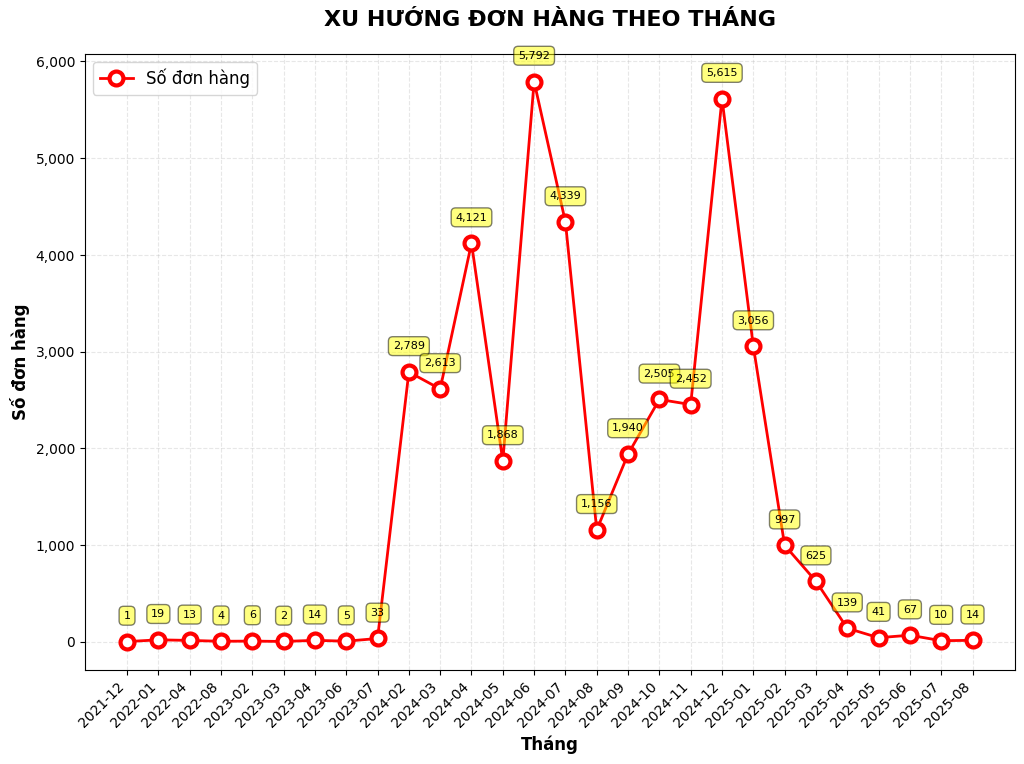

In [167]:
# =============================================================================
# BIỂU ĐỒ ĐƯỜNG - XU HƯỚNG ĐƠN HÀNG THEO THÁNG
# Tạo figure
fig, ax = plt.subplots(figsize=(12, 8))
    
# Vẽ biểu đồ đường
line = ax.plot(range(len(monthly_orders)), 
                monthly_orders.values,
                marker='o', 
                linewidth=2, 
                markersize=10,
                color='red',
                markerfacecolor='white',
                markeredgecolor='red',
                markeredgewidth=3,
                label='Số đơn hàng')

# Customize
ax.set_title('XU HƯỚNG ĐƠN HÀNG THEO THÁNG', 
                fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Tháng', fontsize=12, fontweight='bold')
ax.set_ylabel('Số đơn hàng', fontsize=12, fontweight='bold')

# Set x-axis labels
ax.set_xticks(range(len(monthly_orders)))
ax.set_xticklabels([str(month) for month in monthly_orders.index], 
                    rotation=45, ha='right')

# Thêm giá trị trên mỗi điểm
for i, (x, y) in enumerate(zip(range(len(monthly_orders)), monthly_orders.values)):
    ax.annotate(f'{y:,}', 
                xy=(x, y), 
                xytext=(0, 15), 
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=8,
                bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.5))

# Grid
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Format y-axis với dấu phẩy
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Thêm legend
ax.legend(loc='upper left', fontsize=12)

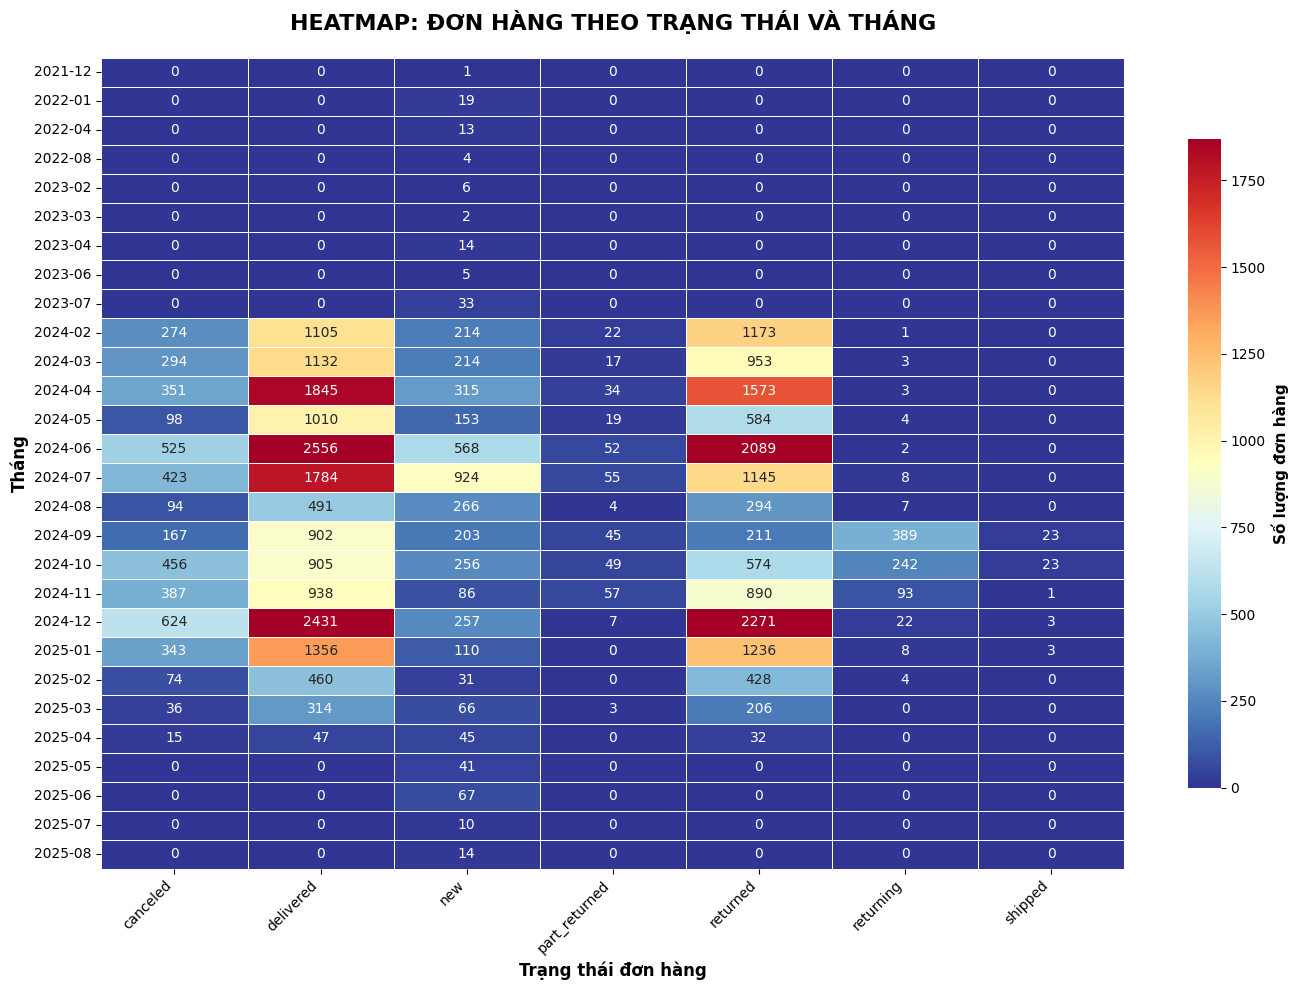

In [168]:
# HEATMAP ĐẸP - ĐƠN HÀNG THEO TRẠNG THÁI VÀ THÁNG

# Tạo pivot table
pivot_data = df_orders.pivot_table(
    values='order_id', 
    index='year_month', 
    columns='status_name', 
    aggfunc='count', 
    fill_value=0
)

# Tạo figure với style đẹp
plt.figure(figsize=(14, 10))

# Vẽ heatmap với custom style
ax = sns.heatmap(pivot_data, 
                 annot=True, 
                 fmt='d', 
                 cmap='RdYlBu_r',  # Màu đẹp hơn
                 linewidths=0.5,   # Đường viền
                 linecolor='white', # Màu đường viền
                 cbar_kws={'shrink': 0.8},  # Customize colorbar
                 square=False,     # Không vuông
                 robust=True)      # Robust scaling

# Customize title
plt.title('HEATMAP: ĐƠN HÀNG THEO TRẠNG THÁI VÀ THÁNG', 
          fontsize=16, fontweight='bold', pad=20)

# Customize labels
plt.xlabel('Trạng thái đơn hàng', fontsize=12, fontweight='bold')
plt.ylabel('Tháng', fontsize=12, fontweight='bold')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Customize colorbar
cbar = ax.collections[0].colorbar
cbar.set_label('Số lượng đơn hàng', fontsize=11, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

## C. Customer Metrics

In [169]:
df_customers.head(2)

,customer_id,name,shop_id,gender,phone,order_count,succeed_order_count,returned_order_count,purchased_amount,last_order_at,inserted_at,updated_at,is_block,is_discount_by_level,active_levera_pay,reward_point,current_debts,count_referrals,referral_code,fb_id,order_sources,conversation_link,address_province_id,address_district_id,address_commune_id,address_full
0,e906c5c7-ea19-42e5-a971-57cf09c94417,Thinh Bui,230361475,Nam,0903693389,1,0,0,0.0,NaT,2025-08-16 02:19:59,2025-08-16 02:19:59,0,1,0,0,0,0,GM5wdxsy,377626778776391_31407011708897267,-1,https://pancake.vn/377626778776391?customer_id=c7a583d6-392d-4308-a02b-67c001ee03db,Unknown,Unknown,Unknown,Unknown
1,6c5b40d2-ae42-4e13-8019-f3f9127d75a0,Truong Minh,230361475,Nam,0907809070,1,0,0,0.0,NaT,2025-08-15 12:56:50,2025-08-15 12:56:50,0,1,0,0,0,0,6zqy77Bu,377626778776391_24536870619280831,-1,https://pancake.vn/377626778776391?customer_id=590ba7de-e4fe-43b3-8013-27fc69937edf,Unknown,Unknown,Unknown,Unknown


### 1. Total Customers (Tổng số khách hàng)

In [170]:
# 1. Total Customers (Tổng số khách hàng)
total_customers = len(df_customers)
print(f"Tổng số khách hàng: {total_customers:,}")

# Phân tích theo giới tính
gender_counts = df_customers['gender'].value_counts()
print("Phân bố theo giới tính:")
for gender, count in gender_counts.items():
    percentage = (count / total_customers) * 100
    print(f"   • {gender}: {count:,} ({percentage:.1f}%)")

Tổng số khách hàng: 36,090
Phân bố theo giới tính:
   • Nữ: 19,486 (54.0%)
   • Nam: 11,239 (31.1%)
   • Unknown: 5,365 (14.9%)


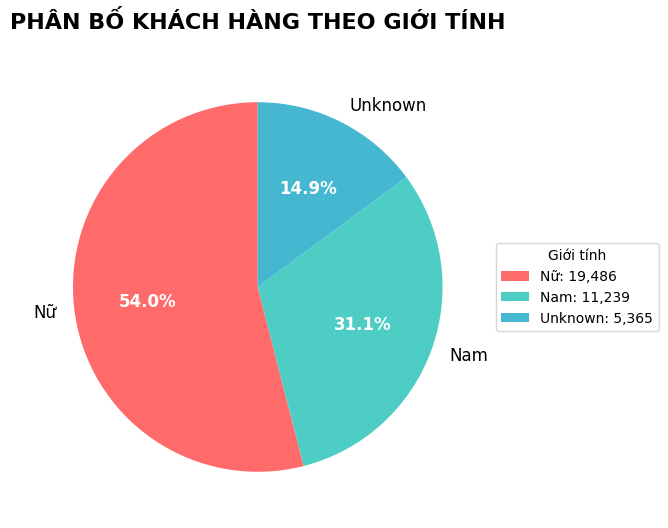

In [180]:
import matplotlib.pyplot as plt

# Tạo figure
fig, ax = plt.subplots(figsize=(8, 6))

# Dữ liệu giới tính
gender_counts = df_customers['gender'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Vẽ biểu đồ tròn
wedges, texts, autotexts = ax.pie(gender_counts.values, 
                                 labels=gender_counts.index,
                                 autopct='%1.1f%%',
                                 colors=colors[:len(gender_counts)],
                                 startangle=90,
                                 textprops={'fontsize': 12})

# Customize
ax.set_title('PHÂN BỐ KHÁCH HÀNG THEO GIỚI TÍNH', 
             fontsize=16, fontweight='bold', pad=20)

# Làm đậm text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

# Legend với số liệu
legend_labels = [f'{label}: {value:,}' for label, value in gender_counts.items()]
ax.legend(wedges, legend_labels, title="Giới tính", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

### 2. New Customers (Khách hàng mới)

In [172]:
df_customers['first_order_date'] = pd.to_datetime(df_customers['inserted_at'])

# Khách hàng mới trong 30 ngày gần nhất
recent_date = df_customers['first_order_date'].max()
thirty_days_ago = recent_date - pd.Timedelta(days=30) 
new_customers_30d = len(df_customers[df_customers['first_order_date'] >= thirty_days_ago])

# Khách hàng mới trong 90 ngày gần nhất
ninety_days_ago = recent_date - pd.Timedelta(days=90)
new_customers_90d = len(df_customers[df_customers['first_order_date'] >= ninety_days_ago])

print(f"Khách hàng mới (30 ngày): {new_customers_30d:,}")
print(f"Khách hàng mới (90 ngày): {new_customers_90d:,}")

# Phân tích theo tháng
df_customers['first_order_month'] = df_customers['first_order_date'].dt.to_period('M')
monthly_new_customers = df_customers.groupby('first_order_month').size()

print("Khách hàng mới theo tháng:")
for month, count in monthly_new_customers.items():
    print(f"   {month}: {count:,}")

Khách hàng mới (30 ngày): 13
Khách hàng mới (90 ngày): 102
Khách hàng mới theo tháng:
   2021-12: 1
   2022-01: 19
   2022-04: 14
   2022-08: 4
   2023-02: 6
   2023-03: 2
   2023-04: 14
   2023-06: 5
   2023-07: 33
   2024-02: 2,601
   2024-03: 2,299
   2024-04: 3,728
   2024-05: 1,662
   2024-06: 5,400
   2024-07: 3,826
   2024-08: 968
   2024-09: 1,768
   2024-10: 2,291
   2024-11: 2,162
   2024-12: 5,059
   2025-01: 2,686
   2025-02: 838
   2025-03: 507
   2025-04: 82
   2025-05: 36
   2025-06: 62
   2025-07: 6
   2025-08: 11


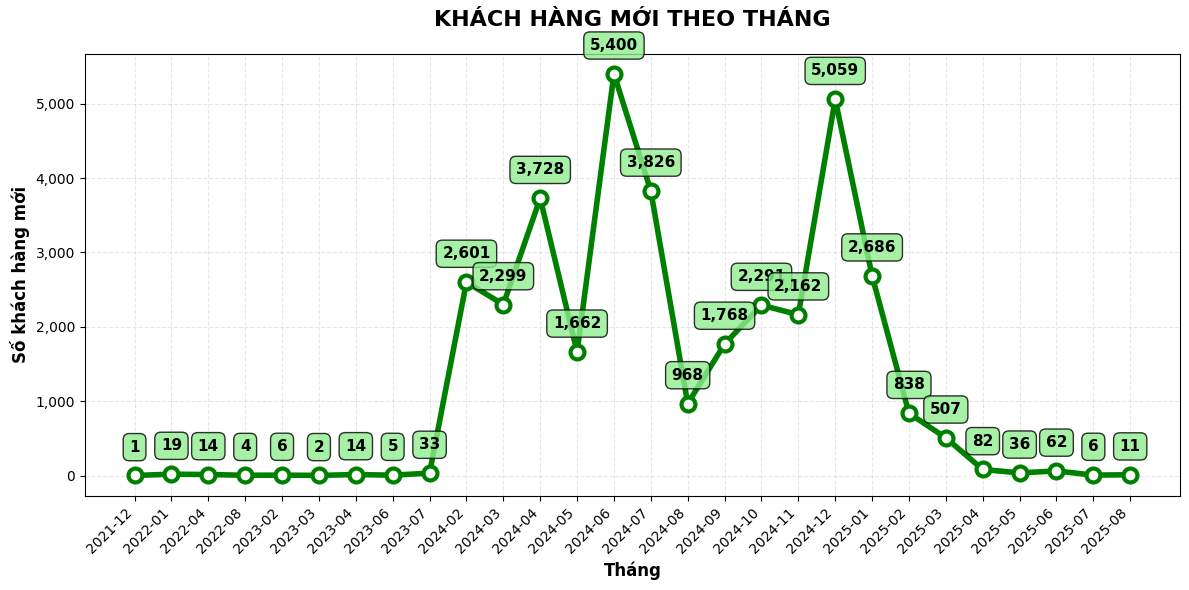

In [182]:
# Tạo figure
fig, ax = plt.subplots(figsize=(12, 6))
    
# Vẽ biểu đồ đường
line = ax.plot(range(len(monthly_new_customers)), 
                monthly_new_customers.values,
                marker='o', 
                linewidth=4, 
                markersize=10,
                color='green',
                markerfacecolor='white',
                markeredgecolor='green',
                markeredgewidth=3,
                label='Khách hàng mới')

# Customize
ax.set_title('KHÁCH HÀNG MỚI THEO THÁNG', 
                fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Tháng', fontsize=12, fontweight='bold')
ax.set_ylabel('Số khách hàng mới', fontsize=12, fontweight='bold')

# Set x-axis labels
ax.set_xticks(range(len(monthly_new_customers)))
ax.set_xticklabels([str(month) for month in monthly_new_customers.index], 
                    rotation=45, ha='right')

# Thêm giá trị trên mỗi điểm
for i, (x, y) in enumerate(zip(range(len(monthly_new_customers)), monthly_new_customers.values)):
    ax.annotate(f'{y:,}', 
                xy=(x, y), 
                xytext=(0, 15), 
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgreen', alpha=0.8))

# Grid
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

### 3. Customer Retention Rate (Tỷ lệ giữ chân khách hàng)

In [173]:
returning_customers = len(df_customers[df_customers['order_count'] > 1])
single_order_customers = len(df_customers[df_customers['order_count'] == 1])

print(f"Khách hàng lặp lại: {returning_customers:,}")
print(f"Khách hàng 1 đơn: {single_order_customers:,}")

# Tỷ lệ retention
retention_rate = (returning_customers / total_customers) * 100
print(f"Tỷ lệ giữ chân: {retention_rate:.2f}%")

# Phân tích chi tiết theo số đơn hàng
order_count_dist = df_customers['order_count'].value_counts().sort_index()
print("Phân bố theo số đơn hàng:")
for orders, count in order_count_dist.items():
    percentage = (count / total_customers) * 100
    print(f"   • {orders} đơn: {count:,} ({percentage:.1f}%)")

Khách hàng lặp lại: 3,494
Khách hàng 1 đơn: 32,594
Tỷ lệ giữ chân: 9.68%
Phân bố theo số đơn hàng:
   • 0 đơn: 2 (0.0%)
   • 1 đơn: 32,594 (90.3%)
   • 2 đơn: 2,989 (8.3%)
   • 3 đơn: 401 (1.1%)
   • 4 đơn: 76 (0.2%)
   • 5 đơn: 17 (0.0%)
   • 6 đơn: 5 (0.0%)
   • 7 đơn: 1 (0.0%)
   • 8 đơn: 3 (0.0%)
   • 9 đơn: 1 (0.0%)
   • 11 đơn: 1 (0.0%)


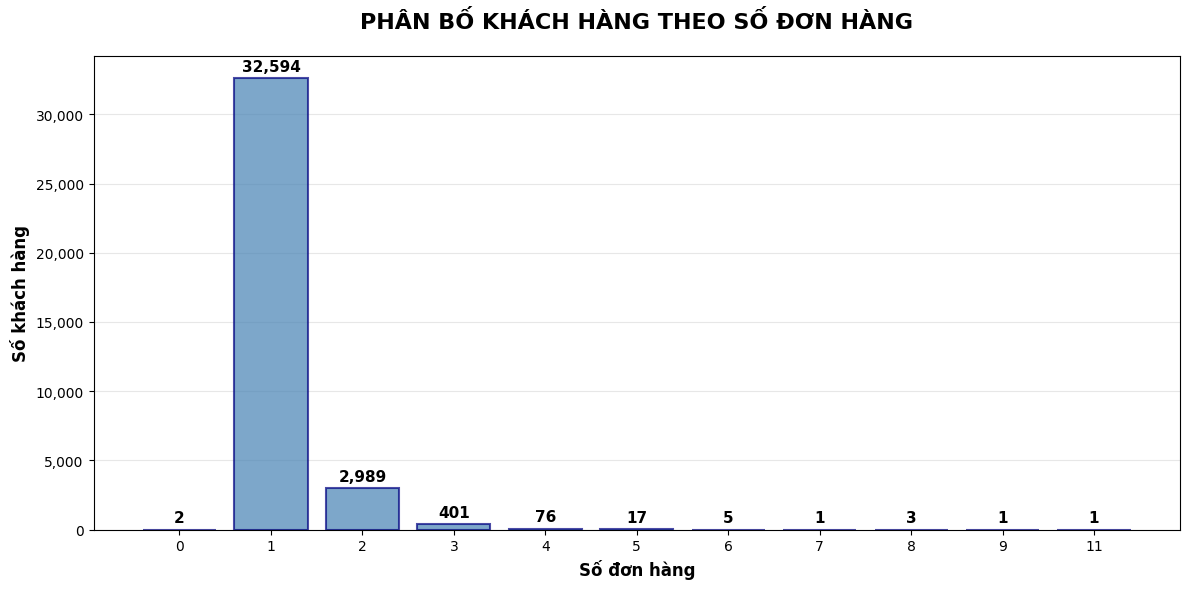

In [184]:
# Tạo figure
fig, ax = plt.subplots(figsize=(12, 6))
    
# Vẽ biểu đồ cột
bars = ax.bar(range(len(order_count_dist)), 
                order_count_dist.values,
                color='steelblue', 
                alpha=0.7,
                edgecolor='navy',
                linewidth=1.5)

# Customize
ax.set_title('PHÂN BỐ KHÁCH HÀNG THEO SỐ ĐƠN HÀNG', 
                fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Số đơn hàng', fontsize=12, fontweight='bold')
ax.set_ylabel('Số khách hàng', fontsize=12, fontweight='bold')

# Set x-axis labels
ax.set_xticks(range(len(order_count_dist)))
ax.set_xticklabels([str(orders) for orders in order_count_dist.index])

# Thêm giá trị trên đầu mỗi cột
for i, (bar, value) in enumerate(zip(bars, order_count_dist.values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(order_count_dist.values)*0.01,
            f'{value:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Grid
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Highlight returning customers (orders > 1)
returning_customers = len(df_customers[df_customers['order_count'] > 1])
single_order_customers = len(df_customers[df_customers['order_count'] == 1])

plt.tight_layout()
plt.show()

# INSIGHT :

💰 REVENUE INSIGHTS:
--------------------------------------------------
- Tổng doanh thu: 17,879,077,900 VND
- Doanh thu sau giảm giá: 16,545,782,490 VND
- Tỷ lệ giảm giá: 7.99%
- AOV: 411,218 VND

- 🔍 INSIGHT: Tỷ lệ giảm giá 7.99% là hợp lý, cho thấy chiến lược pricing cân bằng.
- 🔍 INSIGHT: AOV 411,218 VND khá cao, cho thấy khách hàng có khả năng chi trả tốt.

📦 ORDER INSIGHTS:
--------------------------------------------------
- Tổng đơn hàng: 40,236
- Khách hàng: 36,090
- Đơn hàng/khách hàng: 1.11
- Tỷ lệ hoàn thành: 42.9% (delivered)
- Tỷ lệ trả hàng: 33.9% (returned)

- 🔍 INSIGHT: Tỷ lệ trả hàng 33.9% RẤT CAO - cần phân tích nguyên nhân và cải thiện chất lượng sản phẩm.
- 🔍 INSIGHT: Tỷ lệ hoàn thành 42.9% thấp - cần cải thiện quy trình fulfillment.
- 🔍 INSIGHT: Đơn hàng/khách hàng 1.11 thấp - cần cải thiện retention và upselling.

👥 CUSTOMER INSIGHTS:
--------------------------------------------------
- Tổng khách hàng: 36,090
- Phân bố giới tính: Nữ 54.0%, Nam 31.1%, Unknown 14.9%
- Retention rate: 9.68% (RẤT THẤP)
- Khách hàng 1 đơn: 90.3%
- Khách hàng lặp lại: 9.7%

- 🔍 INSIGHT: Retention rate 9.68% CỰC THẤP - cần xây dựng loyalty program ngay lập tức.
- 🔍 INSIGHT: 90.3% khách hàng chỉ mua 1 lần - cần cải thiện customer experience.
- 🔍 INSIGHT: Nữ giới chiếm đa số (54%) - cần tối ưu sản phẩm cho nữ giới.

📅 TIME-BASED INSIGHTS:
--------------------------------------------------
- Tháng cao nhất: 2024-12 (3,092,223,120 VND)
- Tháng thấp nhất: 2025-04 (25,755,000 VND)
- Tăng trưởng cao nhất: 2024-06 (+259.17%)
- Sụt giảm mạnh nhất: 2025-04 (-87.67%)

- 🔍 INSIGHT: Doanh thu sụt giảm mạnh từ 2025-01 (-47.93%) đến 2025-04 (-87.67%) - CẢNH BÁO NGHIÊM TRỌNG.
- 🔍 INSIGHT: Tháng 12/2024 đạt đỉnh cao - cần phân tích chiến lược để tái tạo thành công.
- 🔍 INSIGHT: Xu hướng giảm mạnh từ đầu 2025 - cần có biện pháp khẩn cấp.